<a href="https://colab.research.google.com/github/tmforai60/zerotsuku3/blob/main/step11_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

目次
- 可変長の引数（順伝播編）
- 可変長の引数（改善編）  
    1. 使う人にとっての改善
    2. 実装する人にとっての改善
- 可変長の引数（逆伝播編）
- 同じ変数を繰り返し使う

In [1]:
# Step10までに作成したコード

import unittest
import numpy as np


class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop()
            x, y = f.input, f.output
            x.grad = f.backward(y.grad)

            if x.creator is not None:
                funcs.append(x.creator)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(as_array(y))
        output.set_creator(self)
        self.input = input
        self.output = output
        return output

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()


class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx


def square(x):
    return Square()(x)


def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(x.data - eps)
    x1 = Variable(x.data + eps)
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y0.data) / (2 * eps)


class SquareTest(unittest.TestCase):
    def test_forward(self):
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)

    def test_backward(self):
        x = Variable(np.array(3.0))
        y = square(x)
        y.backward()
        expected = np.array(6.0)
        self.assertEqual(x.grad, expected)

    def test_gradient_check(self):
        x = Variable(np.random.rand(1))
        y = square(x)
        y.backward()
        num_grad = numerical_diff(square, x)
        flg = np.allclose(x.grad, num_grad)
        self.assertTrue(flg)

## ステップ11：可変長の引数（順伝播編）

可変長…引数（または戻り値）の数が変動すること
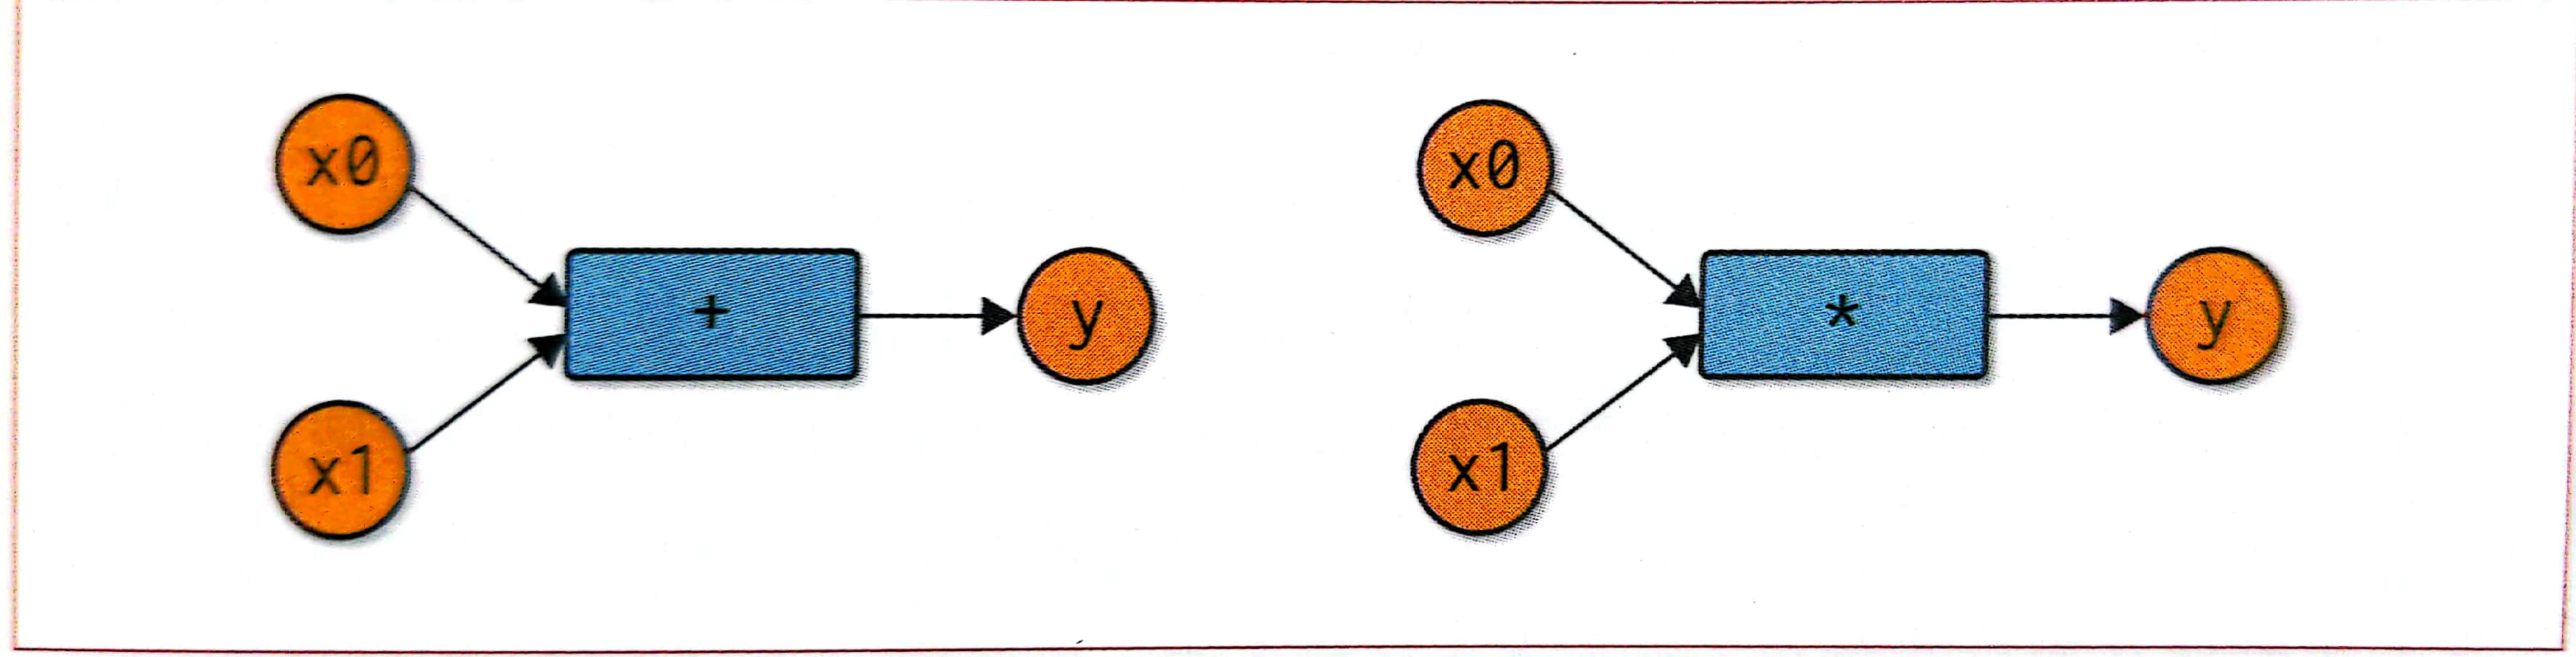


### Functionクラスの修正

In [2]:
# これまでのFunctionクラス

class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(as_array(y))
        output.set_creator(self)
        self.input = input
        self.output = output
        return output

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

In [3]:
# 引数と戻り値をリストに変更

class Function:
  def __call__(self, inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(xs)
    outputs = [Variable(as_array(y)) for y in ys]

    for output in outputs:
      output.set_creator(self)
    self.inputs = inputs
    self.outputs = outputs
    return outputs

  def forward(self, xs):
    raise NotImplementedError()

  def backward(self, xs):
    raise NotImplementedError()

### Addクラスの実装
- Addクラスは２つの引数を取る

In [4]:
class Add(Function):
  def forward(self, xs):
    x0, x1 = xs
    y = x0 + x1
    return (y,)

In [5]:
xs = [Variable(np.array(2)), Variable(np.array(3))]
f = Add()
ys = f(xs)
y = ys[0]
print(y.data)

5


## ステップ12： 可変数の引数（改善編）
- ステップ11の実装の課題
    1. Addクラスを使うたびに入力変数としてリストを作らないといけない
    2. 戻り値がタプルになっている

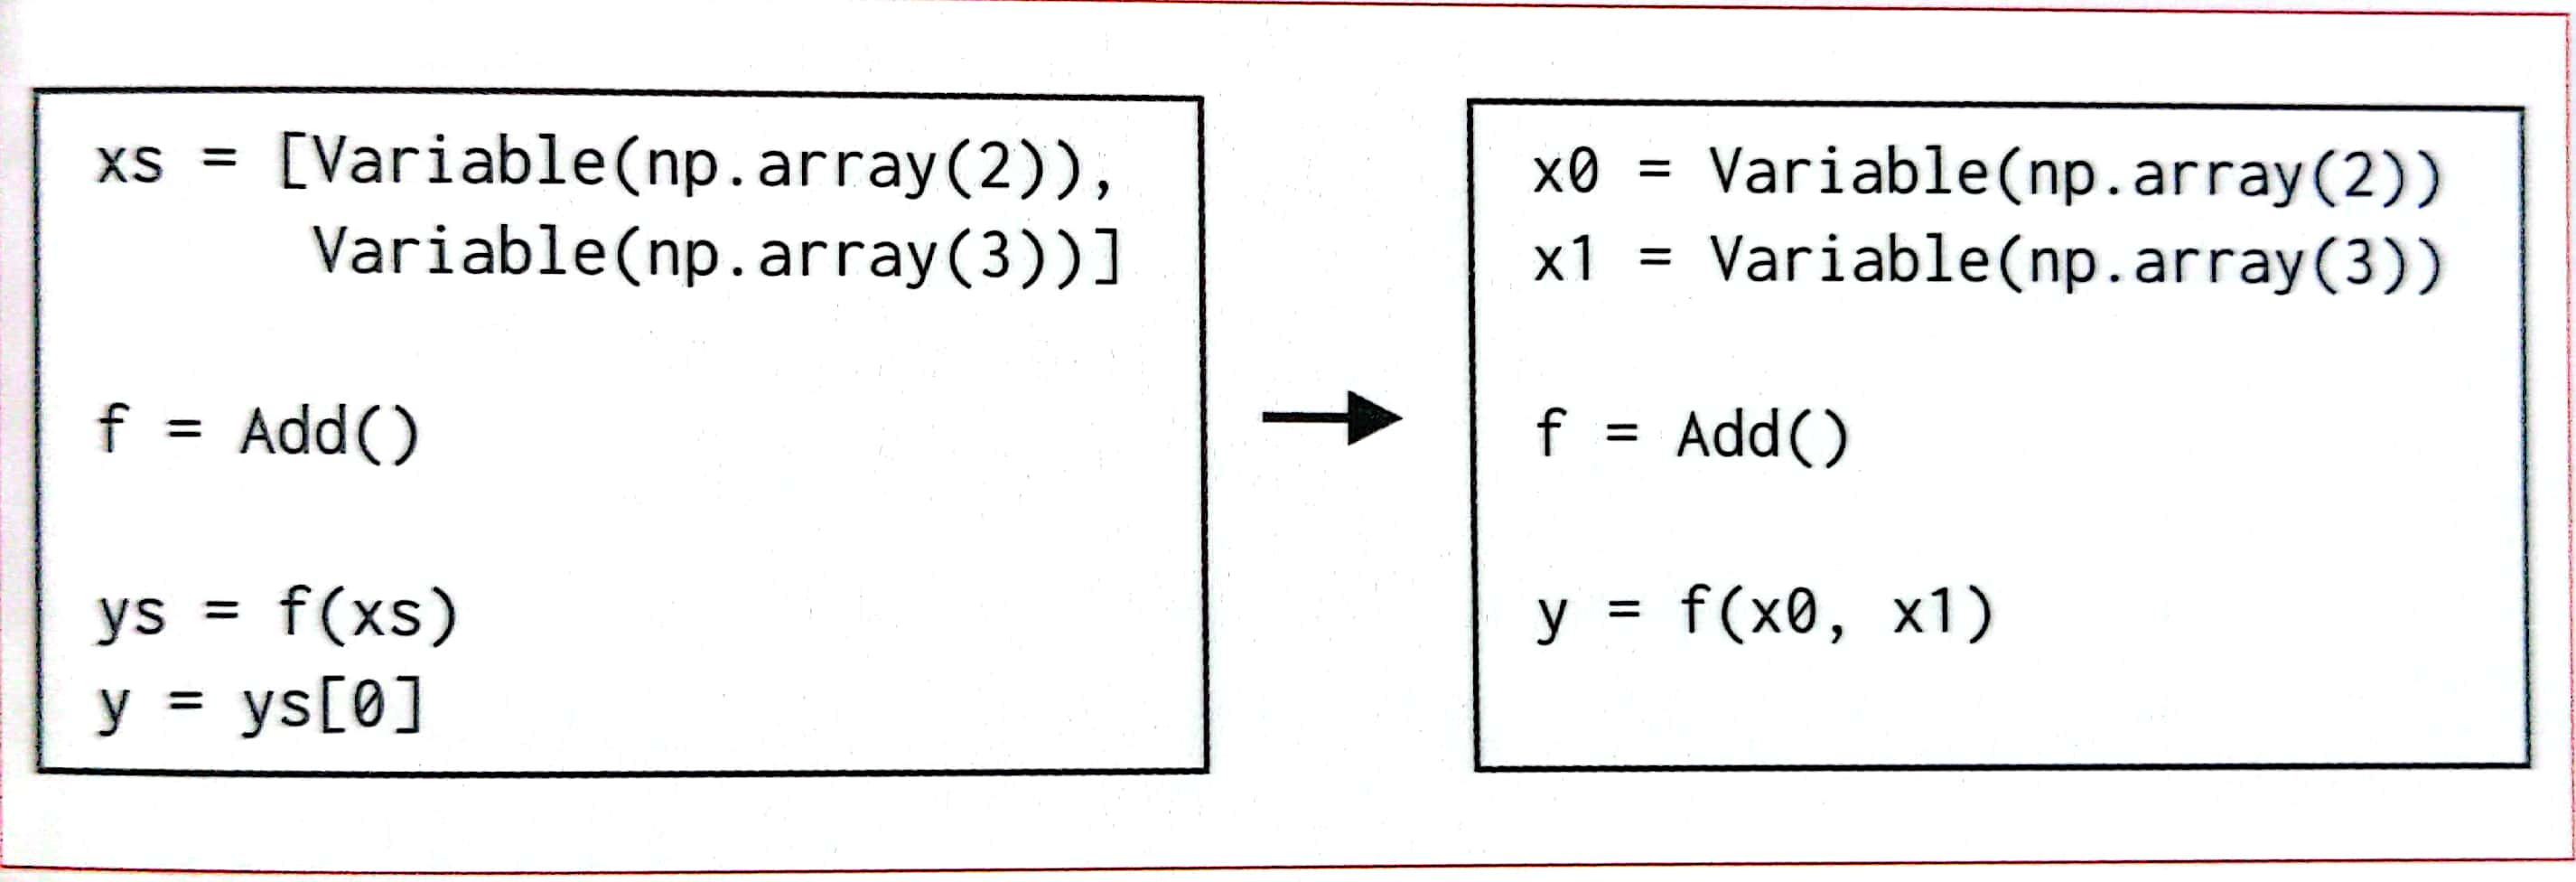

### 問題1の改善

In [6]:
class Function:
  def __call__(self, *inputs): #
    xs = [x.data for x in inputs]
    ys = self.forward(xs)
    outputs = [Variable(as_array(y)) for y in ys]

    for output in outputs:
      output.set_creator(self)
    self.inputs = inputs
    self.outputs = outputs

    return outputs if len(outputs) > 1 else outputs[0]  #

In [7]:
# 再掲
class Add(Function):
  def forward(self, xs):
    x0, x1 = xs
    y = x0 + x1
    return (y,)

In [41]:
# 可変数引数の例
def test(*x):
  print('x:', x)
  print('type(x)', type(x))
  print('----------')

test(1, 2, 3)
test(1, 2, 3, 4, 5, 6)
test(1)

x: (1, 2, 3)
type(x) <class 'tuple'>
----------
x: (1, 2, 3, 4, 5, 6)
type(x) <class 'tuple'>
----------
x: (1,)
type(x) <class 'tuple'>
----------


In [44]:
# 可変数引数の例２

def test2(*x):
  print(x[0] + x[2])

test2(1, 3, 4)

5


In [45]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
f = Add()
y = f(x0, x1)
print(y.data)

5


### 問題２の改善


forwardメソッドの引数は変数を直接受け取り、結果の変数も直接返すほうが、実装者にとってわかりやすい。

In [10]:
# 変更前のfunctionクラス

class Function:
  def __call__(self, *inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(xs)
    outputs = [Variable(as_array(y)) for y in ys]

    for output in outputs:
      output.set_creator(self)
    self.inputs = inputs
    self.outputs = outputs

    return outputs if len(outputs) > 1 else outputs[0]

In [11]:
# 変更後のfunctionクラス

class Function:
  def __call__(self, *inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(*xs)  # 関数呼び出し時のアスタリスク→アンパック
    if not isinstance(ys, tuple):
      ys = (ys,)  #
    outputs = [Variable(as_array(y)) for y in ys]
    
    for output in outputs:
      output.set_creator(self)
    self.inputs = inputs
    self.outputs = outputs

    return outputs if len(outputs) > 1 else outputs[0]

In [12]:
# 再掲

class Add(Function):
  def forward(self, xs):
    x0, x1 = xs
    y = x0 + x1
    return (y,)

In [13]:
# 問題（Addクラスを上のFunctionクラスの変更にあわせて修正してください。）

class Add(Function):
  def forward(self, x0, x1):
    y = x0 + x1
    return y

In [46]:
def add(x0, x1):
  return Add()(x0, x1)

x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
y = add(x0, x1)
print(y.data)

5


## 可変長の引数（逆伝播編）

In [15]:
class Add(Function):
  def forward(self, x0, x1):
    y = x0 + x1
    return y

  def backward(self, gy):
    return gy, gy

In [16]:
# 変更前のVariableクラス

class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.grad = None
        self.creator = None

    def set_creator(self, func):
        self.creator = func

    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = [self.creator]
        while funcs:
            f = funcs.pop() 
            x, y = f.input, f.output  #　関数の入出力を取得
            x.grad = f.backward(y.grad) # backwardメソッドを呼ぶ

            if x.creator is not None:
                funcs.append(x.creator)

In [17]:
# 入力が複数に対応したVariableクラス

class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))
      
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func
  
  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)
    
    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs] #
      gxs = f.backward(*gys) #
      if not isinstance(gxs, tuple): #
        gxs = (gxs,) #
      
      for x, gx in zip(f.inputs, gxs): #
        x.grad = gx #

        if x.creator is not None: #
          funcs.append(x.creator) #

In [20]:
class Square(Function):
  def forward(self, x):
    y = x ** 2
    return y
  
  def backward(self, gy):
    x = self.inputs[0].data
    gx = 2 * x * gy
    return gx

In [21]:
x = Variable(np.array(2.0))
y = Variable(np.array(3.0))

z = add(square(x), square(y))
z.backward()
print(z.data)
print(x.grad)
print(y.grad)

13.0
4.0
6.0


z = x^2 + y^2という計算を行いました。この計算はDeZeroを使えばz = add(square(x), square(y))と書くことができる。そしてその後はz.backward()を呼ぶだけで自動で微分が求められる！

複数の入出力に対応した自動微分の仕組みが完了。

## ステップ14： 同じ変数を繰り返し使う

前ステップまでに複数の入出力に対応した自動微分の仕組みが完了した。しかし、同じ変数を繰り返し使おうとすると、問題が発生する。

In [23]:
x = Variable(np.array(3.0))
y = add(x, x)
print('y', y.data)

y.backward() # →正しい
print('x.grad', x.grad) # →間違い

y 6.0
x.grad 1.0


In [ ]:
# 現状のVariableクラス

class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))
      
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func
  
  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)
    
    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        x.grad = gx # ここが問題！

        if x.creator is not None:
          funcs.append(x.creator)

In [26]:
# 修正後のVariableクラス

class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))
      
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func
  
  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)
    
    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None: #
          x.grad = gx #
        else: #
          x.grad = x.grad + gx #

        if x.creator is not None:
          funcs.append(x.creator)

In [27]:
x = Variable(np.array(3.0))
y = add(x, x)
print('y', y.data)

y.backward() # →正しい
print('x.grad', x.grad) # →間違い

y 6.0
x.grad 2.0


In [49]:
# xを３回使って足し算

x = Variable(np.array(3.0))
y = add(add(x, x), x)
y.backward()
print(x.grad)

3.0


###微分のリセット

#### 同じ変数を使って別の計算を行う場合、初期化しないと前の結果が影響してしまう。

In [34]:
#1回目の計算
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad) # ->正

#2回目の計算
y = add(add(x, x), x)
y.backward()
print(x.grad) #　->　誤

2.0
5.0


In [35]:
# Variableクラスにcleargradを追加

class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{} is not supported'.format(type(data)))
      
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func
  
  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)
    
    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs,)
      
      for x, gx in zip(f.inputs, gxs):
        if x.grad is None: #
          x.grad = gx #
        else: #
          x.grad = x.grad + gx #

        if x.creator is not None:
          funcs.append(x.creator)
          
  def cleargrad(self):
    self.grad = None

In [36]:
#1回目の計算
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad) # ->正

#2回目の計算
x.cleargrad()
y = add(add(x, x), x)
y.backward()
print(x.grad) #　->　誤

2.0
3.0
